In [1]:
import meep as mp
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------
# Simulation parameters
# -----------------------------
resolution = 8  # pixels/um

# Materials
gaas = mp.Medium(epsilon=12)
air = mp.Medium(epsilon=1)

# Disk and waveguide geometry
disk_radius = 3.5
wg_length = 40
wg_width = 0.22
gap = 0.08  # distance between disk and waveguides

# Simulation cell size
cell_x = wg_length + 10
cell_y = 2*(disk_radius + gap + wg_width/2) + 10
cell = mp.Vector3(cell_x, cell_y, 0)

# PML layers
pml_layers = [mp.PML(2.0)]

# -----------------------------
# Geometry: disk + two waveguides
# -----------------------------
geometry = [
    mp.Cylinder(radius=disk_radius, height=mp.inf, center=mp.Vector3(0,0), material=gaas),
    mp.Block(size=mp.Vector3(wg_length, wg_width, mp.inf),
             center=mp.Vector3(0, disk_radius + gap + wg_width/2),
             material=gaas),
    mp.Block(size=mp.Vector3(wg_length, wg_width, mp.inf),
             center=mp.Vector3(0, -disk_radius - gap - wg_width/2),
             material=gaas)
]


-----------
Initializing structure...
time for choose_chunkdivision = 0.00412297 s
Working in 2D dimensions.
Computational cell is 50 x 17.4 x 0 with resolution 20
     cylinder, center = (0,0,0)
          radius 3.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,3.69,0)
          size (40,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-3.69,0)
          size (40,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 1.04756 s
-----------
on time step 674 (time=16.85), 0.00594118 s/step
on time step 1438 (time=35.95), 0.0052385 s/step
field decay(t = 50.025000000000006): 6.265343838108534e-12 / 6.265343838108534e-12 = 1.0
on time step 2575 (time=64.375), 0.00352045 s/step
on time step 3359 (time=83.975), 0.00510803 s/step
field decay(t = 100.0500000000

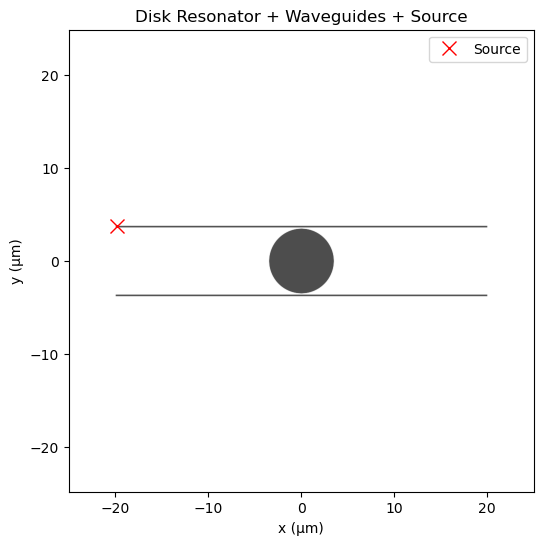

Maximum transmission: 63.7257 at frequency 0.3311 (1/µm)


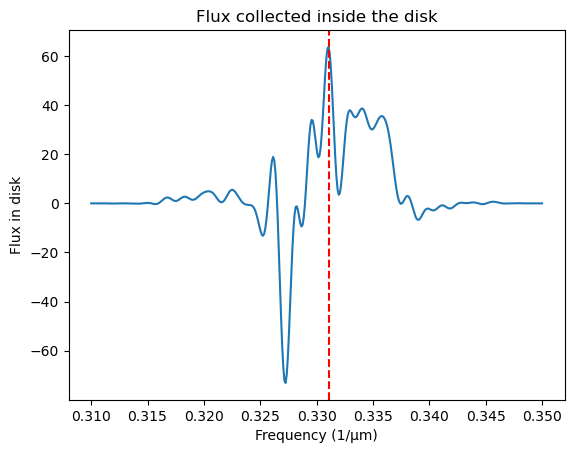

FloatProgress(value=900.4500122070312, description='0% done ', max=1000.4500122070312, min=900.4500122070312)

on time step 36426 (time=910.65), 0.00645592 s/step
Meep progress: 10.774987792968773/1000.4500122070312 = 1.1% done in 4.0s, 367.8s to go
on time step 36969 (time=924.225), 0.00736707 s/step
Meep progress: 24.32498779296884/1000.4500122070312 = 2.4% done in 8.0s, 321.5s to go
on time step 37494 (time=937.35), 0.00763415 s/step
Meep progress: 37.27498779296877/1000.4500122070312 = 3.7% done in 12.0s, 310.4s to go
on time step 37957 (time=948.925), 0.00864468 s/step
Meep progress: 49.54998779296875/1000.4500122070312 = 5.0% done in 16.0s, 307.3s to go
on time step 38571 (time=964.275), 0.00652004 s/step
Meep progress: 64.3749877929688/1000.4500122070312 = 6.4% done in 20.0s, 291.2s to go
on time step 39215 (time=980.375), 0.00621911 s/step
Meep progress: 80.8749877929688/1000.4500122070312 = 8.1% done in 24.0s, 273.2s to go
on time step 39896 (time=997.4), 0.00587568 s/step
Meep progress: 97.82498779296884/1000.4500122070312 = 9.8% done in 28.0s, 258.7s to go
run 1 finished at t = 1000.

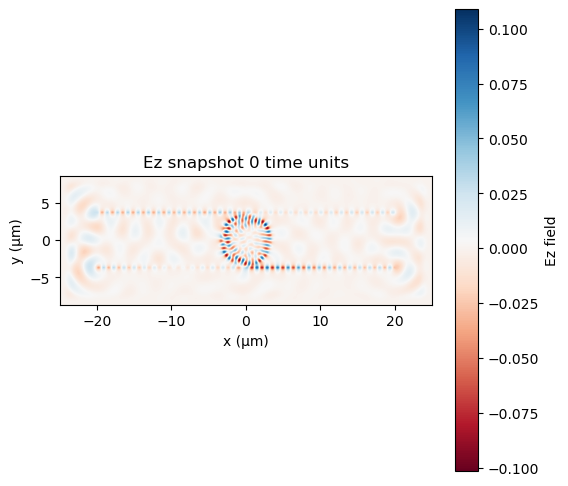

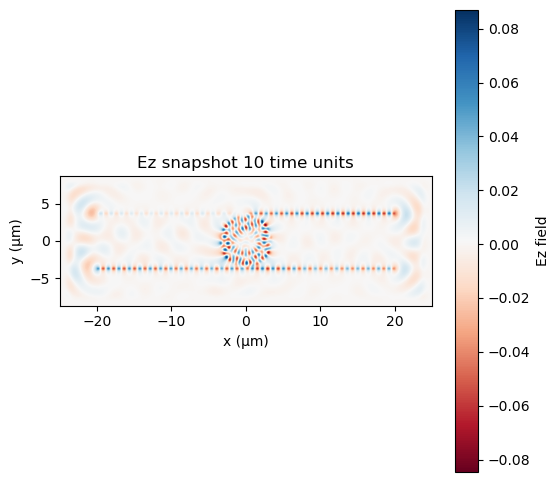

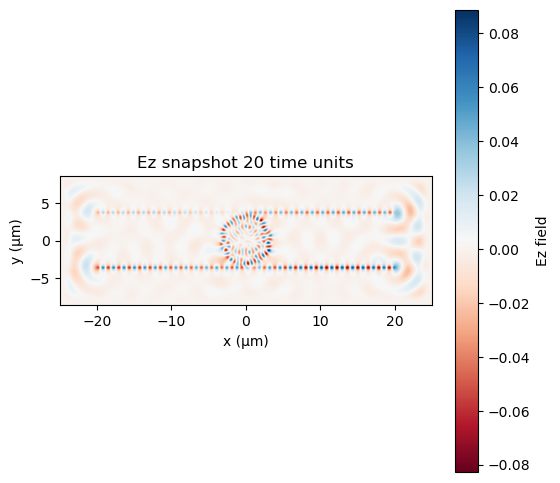

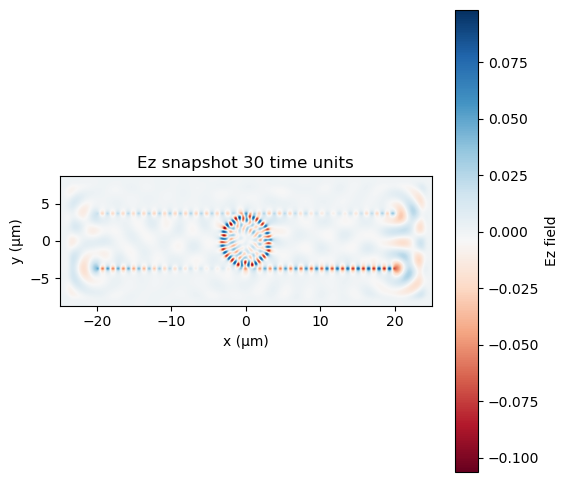

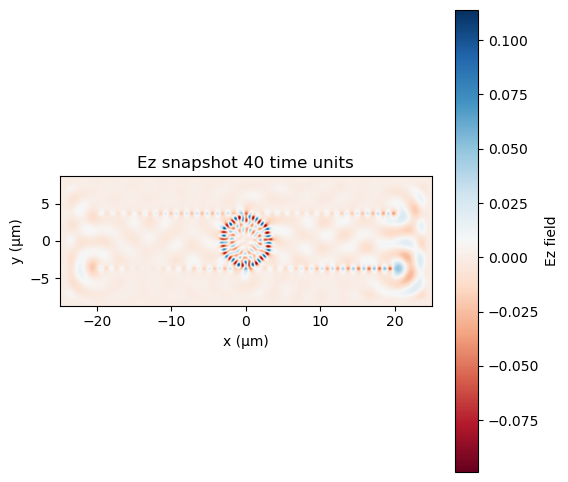

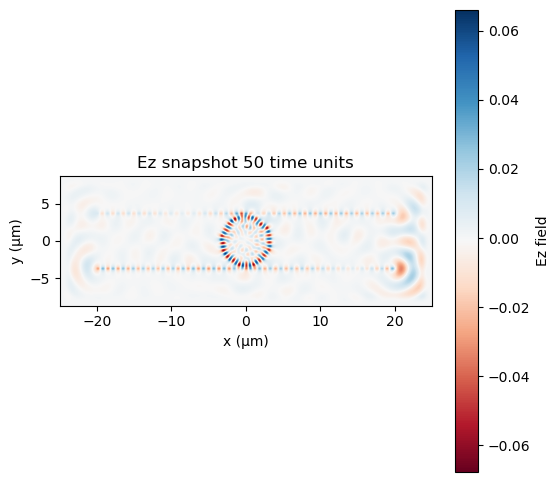

In [8]:

# -----------------------------
# Source
# -----------------------------
source_x = -wg_length/2 + 0.2
source_y = disk_radius + gap + wg_width/2

fmin = 0.31
fmax = 0.35
df = fmax - fmin
nfreq = 400

resolution = 20  # pixels/um

sources = [mp.Source(mp.GaussianSource(frequency=(fmin+fmax)/2, fwidth=df),
                     component=mp.Ez,
                     center=mp.Vector3(source_x, source_y),
                     size=mp.Vector3(0, 0, 0))]

# -----------------------------
# Flux monitor: inside disk
# -----------------------------
flux_region = mp.FluxRegion(center=mp.Vector3(0,0), size=mp.Vector3(0, 2*disk_radius, 0))

# -----------------------------
# Simulation
# -----------------------------
sim = mp.Simulation(cell_size=cell,
                    geometry=geometry,
                    sources=sources,
                    boundary_layers=pml_layers,
                    resolution=resolution)


trans_flux = sim.add_flux((fmin+fmax)/2, df, nfreq, flux_region)

# Run until fields decay
sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, mp.Vector3(0,0), 1e-2))

# -----------------------------
# Extract flux
# -----------------------------
frequencies = np.array(mp.get_flux_freqs(trans_flux))
transmission = np.array(mp.get_fluxes(trans_flux))

# -----------------------------
# Plot geometry (dielectric + source)
# -----------------------------
eps = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Dielectric)
plt.figure(figsize=(6,6))
plt.imshow(eps.T, origin='lower', extent=[-cell_x/2, cell_x/2, -cell_y/2, cell_y/2], cmap='Greys', alpha=0.7)
plt.plot(source_x, source_y, 'rx', markersize=10, label='Source')
plt.xlabel("x (µm)")
plt.ylabel("y (µm)")
plt.axis('equal')
plt.title("Disk Resonator + Waveguides + Source")
plt.legend()
plt.show()

# -----------------------------
# Plot flux inside disk
# -----------------------------

# Find max transmission and corresponding frequency
max_idx = np.argmax(transmission)
max_val = transmission[max_idx]
max_freq = frequencies[max_idx]

print(f"Maximum transmission: {max_val:.4f} at frequency {max_freq:.4f} (1/µm)")

plt.figure()
plt.plot(frequencies, transmission)
plt.axvline(max_freq, color='red', ls='--', label=f"Max at {max_freq:.3f}")
plt.xlabel("Frequency (1/µm)")
plt.ylabel("Flux in disk")
plt.title("Flux collected inside the disk")
plt.show()

# -----------------------------
# Store Ez snapshots
# -----------------------------
ez_data = []

def store_fields(sim):
    # full cell Ez field
    ez_data.append(sim.get_array(center=mp.Vector3(), size=cell, component=mp.Ez))

# Run simulation and store fields every 2 time units
sim.run(mp.at_every(2, store_fields), until=100)

# -----------------------------
# Plot some snapshots
# -----------------------------
for i, field in enumerate(ez_data[::10]):  # plot every 5th snapshot
    plt.figure(figsize=(6,6))
    plt.imshow(np.rot90(field), cmap="RdBu", origin="lower",
               extent=[-cell_x/2, cell_x/2, -cell_y/2, cell_y/2])
    plt.colorbar(label="Ez field")
    plt.title(f"Ez snapshot {i*5*2} time units")
    plt.xlabel("x (µm)")
    plt.ylabel("y (µm)")
    plt.show()


-----------
Initializing structure...
time for choose_chunkdivision = 0.000658989 s
Working in 2D dimensions.
Computational cell is 50 x 17.3667 x 0 with resolution 30
     cylinder, center = (0,0,0)
          radius 3.5, height 1e+20, axis (0, 0, 1)


          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,3.69,0)
          size (40,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-3.69,0)
          size (40,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 1.54561 s
-----------
on time step 304 (time=5.06667), 0.0131719 s/step
on time step 634 (time=10.5667), 0.0121236 s/step
on time step 1153 (time=19.2167), 0.00773195 s/step
on time step 1400 (time=23.3333), 0.0162346 s/step
on time step 1630 (time=27.1667), 0.0174288 s/step
on time step 1859 (time=30.9833), 0.0174707 s/step
on time step 1992 (time=33.2), 0.0301726 s/step
on time step 2194 (time=36.5667), 0.0198672 s/step
on time step 2456 (time=40.9333), 0.015294 s/step
on time step 2828 (time=47.1333), 0.0107719 s/step
field decay(t = 50.016666666666666): 3.7577773557767035e-11 /

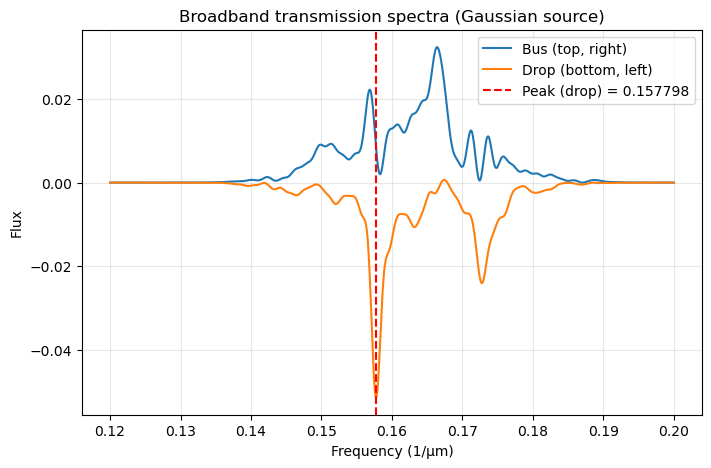

-----------
Initializing structure...
time for choose_chunkdivision = 0.000923872 s
Working in 2D dimensions.
Computational cell is 50 x 17.3667 x 0 with resolution 30
     cylinder, center = (0,0,0)
          radius 3.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,3.69,0)
          size (40,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-3.69,0)
          size (40,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 1.29958 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 5.433333333333334/1000.0 = 0.5% done in 4.0s, 732.8s to go
on time step 326 (time=5.43333), 0.0122713 s/step
Meep progress: 11.15/1000.0 = 1.1% done in 8.0s, 710.6s to go
on time step 669 (time=11.15), 0.0116852 s/step
Meep progress: 16.85/1000.0 = 1.7% done in 12.0s, 701.3s to go
on time step 1011 (time=16.85), 0.0117119 s/step
Meep progress: 22.416666666666668/1000.0 = 2.2% done in 16.0s, 698.7s to go
on time step 1345 (time=22.4167), 0.0119784 s/step
Meep progress: 27.849999999999998/1000.0 = 2.8% done in 20.0s, 699.1s to go
on time step 1671 (time=27.85), 0.0122859 s/step
Meep progress: 36.733333333333334/1000.0 = 3.7% done in 24.0s, 630.3s to go
on time step 2204 (time=36.7333), 0.00751951 s/step
Meep progress: 42.35/1000.0 = 4.2% done in 28.0s, 634.2s to go
on time step 2541 (time=42.35), 0.0118975 s/step
Meep progress: 47.95/1000.0 = 4.8% done in 32.1s, 636.4s to go
on time step 2877 (time=47.95), 0.0119159 s/step
Meep progress: 53.416666666666664/1000.0 = 5.3% do

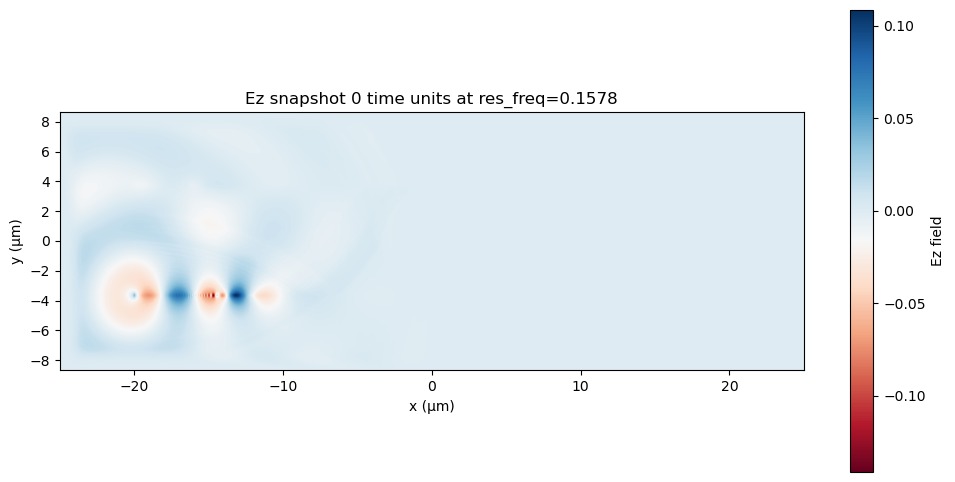

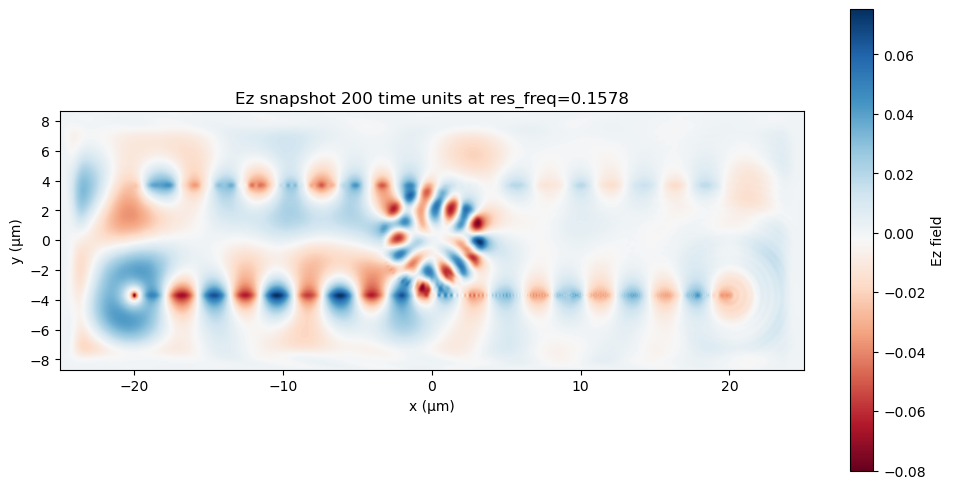

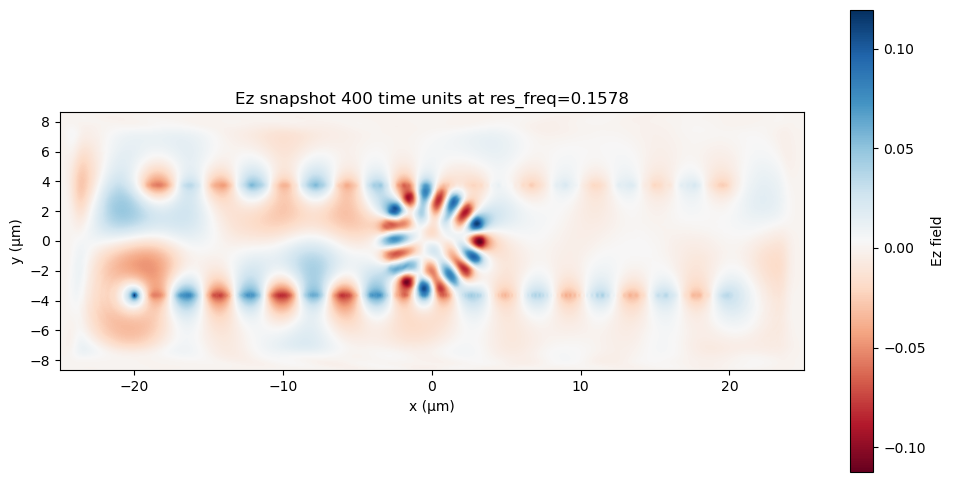

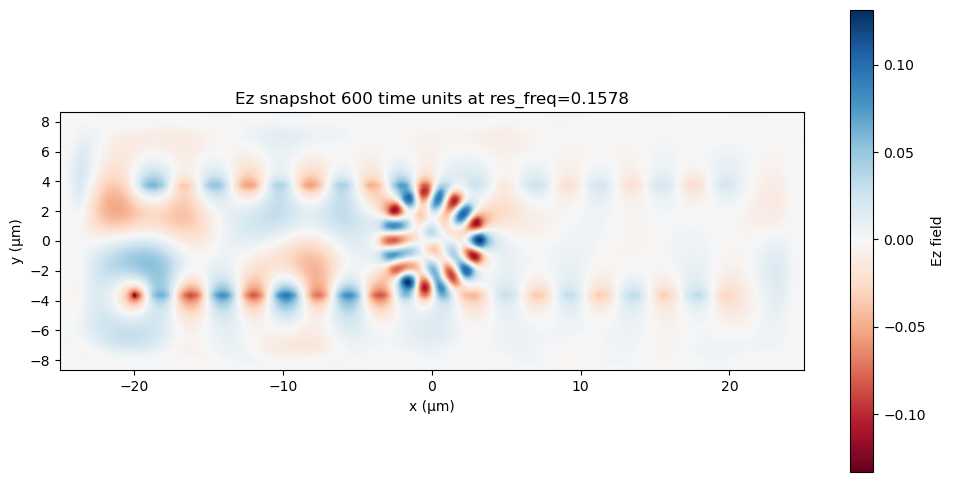

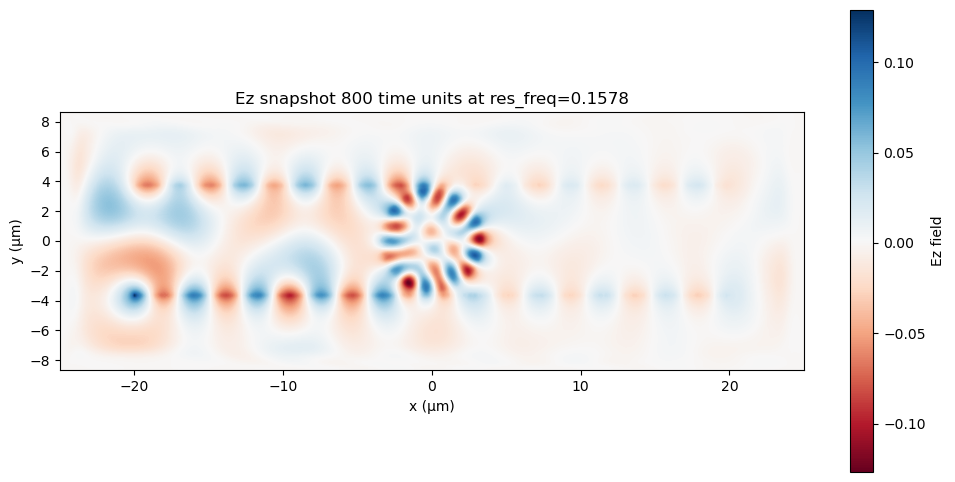

In [10]:

# -----------------------------
# Source (broadband run)
# -----------------------------
source_x = -wg_length/2
source_y = disk_radius + gap + wg_width/2

fmin = 0.12
fmax = 0.2
df = fmax - fmin
nfreq = 1000
resolution = 30  # pixels/um

sources = [mp.Source(mp.GaussianSource(frequency=(fmin+fmax)/2, fwidth=df),
                     component=mp.Ez,
                     center=mp.Vector3(source_x, source_y),
                     size=mp.Vector3(0, wg_width, 0))]

# -----------------------------
# Flux monitors
# -----------------------------
flux_region_bus = mp.FluxRegion(center=mp.Vector3(wg_length/2 - 1,
                                                  disk_radius + gap + wg_width/2),
                                size=mp.Vector3(0, wg_width, 0))

# Drop port moved to left side of lower waveguide (same side as source, opposite waveguide)
flux_region_drop = mp.FluxRegion(center=mp.Vector3(-wg_length/2 + 1,
                                                   -disk_radius - gap - wg_width/2),
                                 size=mp.Vector3(0, wg_width, 0))

# -----------------------------
# First Simulation (spectra)
# -----------------------------
sim = mp.Simulation(cell_size=cell,
                    geometry=geometry,
                    sources=sources,
                    boundary_layers=pml_layers,
                    resolution=resolution)

trans_flux_bus = sim.add_flux((fmin+fmax)/2, df, nfreq, flux_region_bus)
trans_flux_drop = sim.add_flux((fmin+fmax)/2, df, nfreq, flux_region_drop)

sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, mp.Vector3(), 5e-3))

frequencies = np.array(mp.get_flux_freqs(trans_flux_bus))
flux_bus = np.array(mp.get_fluxes(trans_flux_bus))
flux_drop = np.array(mp.get_fluxes(trans_flux_drop))

# -----------------------------
# Find resonance from max |flux_drop|
# -----------------------------
res_freq = frequencies[np.argmax(np.abs(flux_drop))]
print(f"Resonance frequency (max |drop port|): {res_freq:.6f} 1/um")

# -----------------------------
# Plot broadband spectra
# -----------------------------
plt.figure(figsize=(8,5))
plt.plot(frequencies, flux_bus, label='Bus (top, right)')
plt.plot(frequencies, flux_drop, label='Drop (bottom, left)')
plt.axvline(res_freq, color='r', ls='--', label=f'Peak (drop) = {res_freq:.6f}')
plt.xlabel('Frequency (1/µm)')
plt.ylabel('Flux')
plt.title('Broadband transmission spectra (Gaussian source)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# -----------------------------
# Second Simulation (single freq)
# -----------------------------
sources_res = [mp.Source(mp.ContinuousSource(frequency=res_freq),
                         component=mp.Ez,
                         center=mp.Vector3(source_x, source_y),
                         size=mp.Vector3(0, wg_width, 0))]

sim_res = mp.Simulation(cell_size=cell,
                        geometry=geometry,
                        sources=sources_res,
                        boundary_layers=pml_layers,
                        resolution=resolution)

ez_data = []
def store_fields(sim):
    ez_data.append(sim.get_array(center=mp.Vector3(),
                                 size=cell,
                                 component=mp.Ez))

sim_res.run(mp.at_every(20, store_fields), until=1000)

# -----------------------------
# Plot Ez snapshots
# -----------------------------
for i, field in enumerate(ez_data):
    if i % 10 == 0:
        plt.figure(figsize=(12,6))
        plt.imshow(np.rot90(field), cmap="RdBu", origin="lower",
                   extent=[-cell_x/2, cell_x/2, -cell_y/2, cell_y/2])
        plt.colorbar(label="Ez field")
        plt.title(f"Ez snapshot {i*20} time units at res_freq={res_freq:.4f}")
        plt.xlabel("x (µm)")
        plt.ylabel("y (µm)")
        plt.show()

-----------
Initializing structure...
time for choose_chunkdivision = 0.000370026 s
Working in 2D dimensions.
Computational cell is 50 x 17.9 x 0 with resolution 20
     cylinder, center = (0,0,0)
          radius 3.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,3.95,0)
          size (40,0.3,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-3.95,0)
          size (40,0.3,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.687291 s
-----------
on time step 761 (time=19.025), 0.00525898 s/step
on time step 1857 (time=46.425), 0.00365318 s/step
field decay(t = 50.025000000000006): 1.0632146155478536e-09 / 1.0632146155478536e-09 = 1.0
on time step 2586 (time=64.65), 0.00548757 s/step
on time step 3309 (time=82.725), 0.00553638 s/step
field decay(t = 100.050000

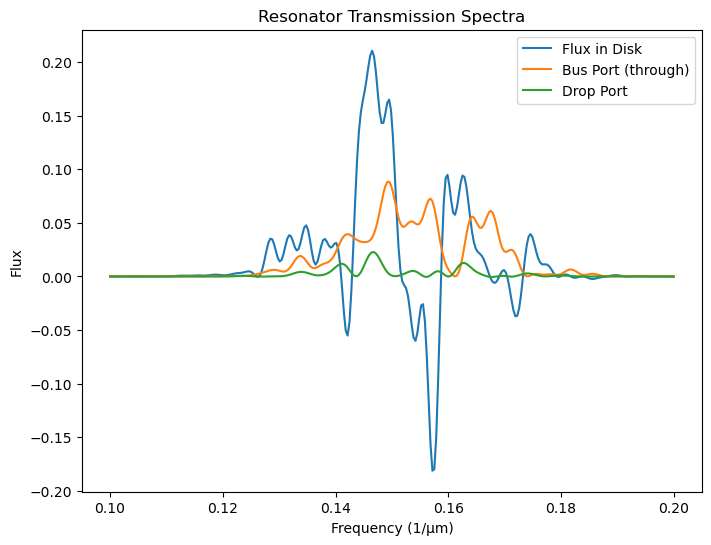

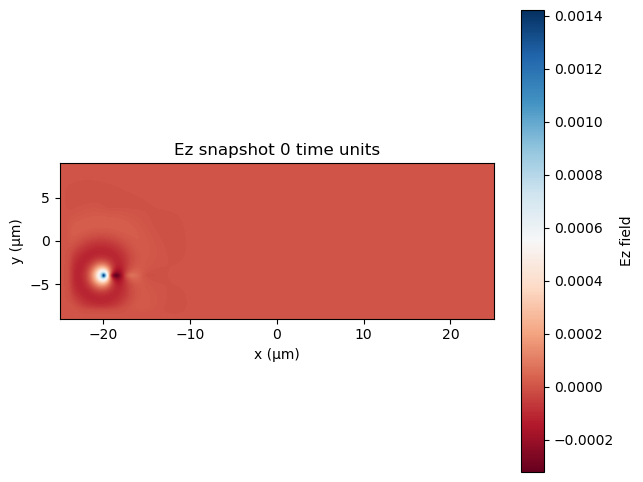

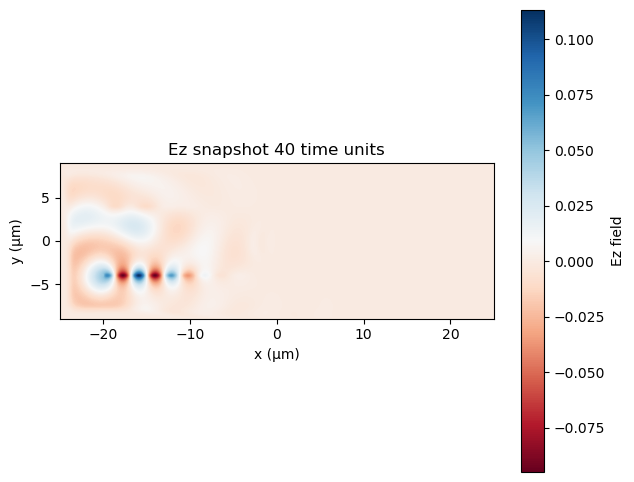

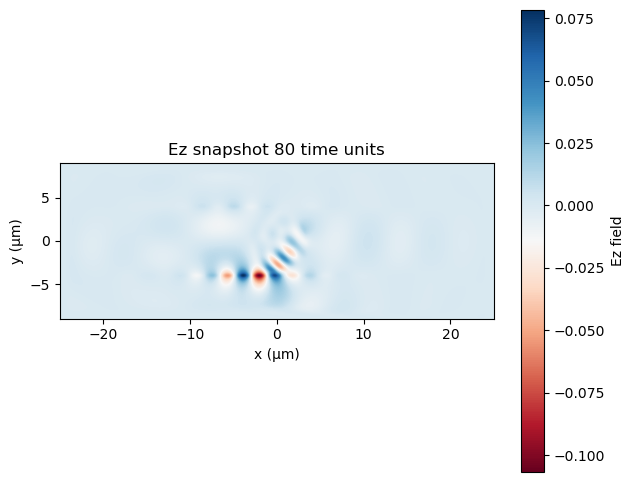

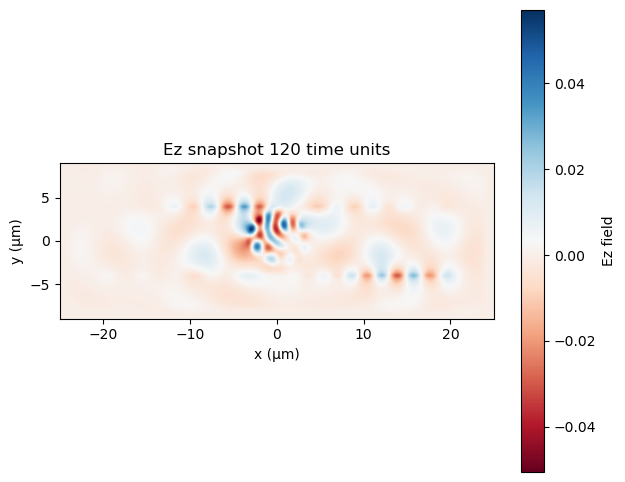

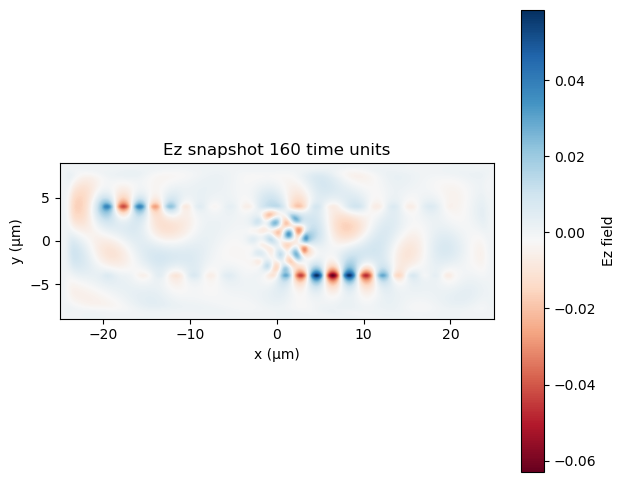

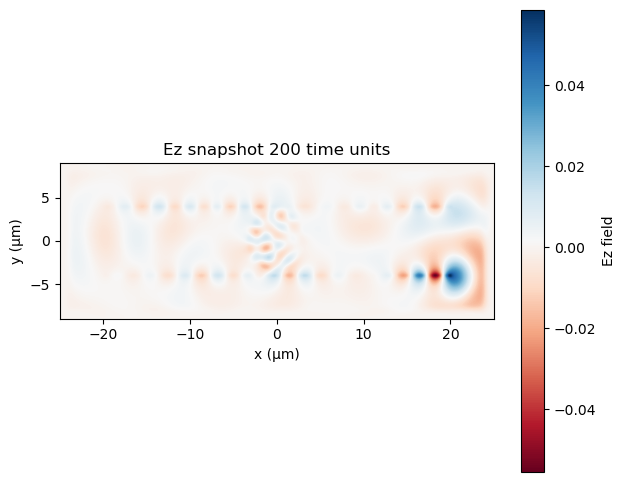

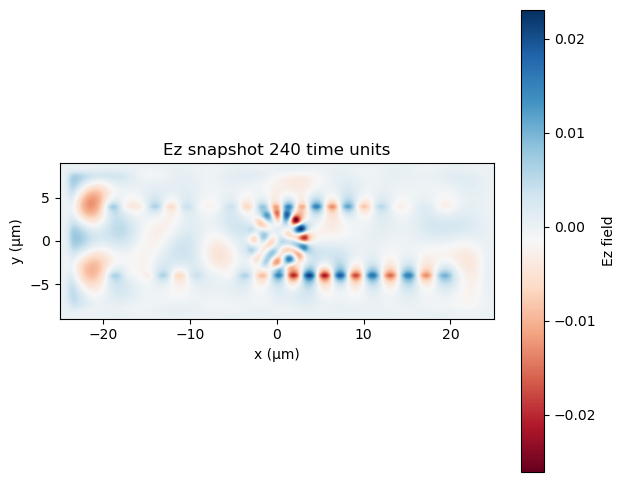

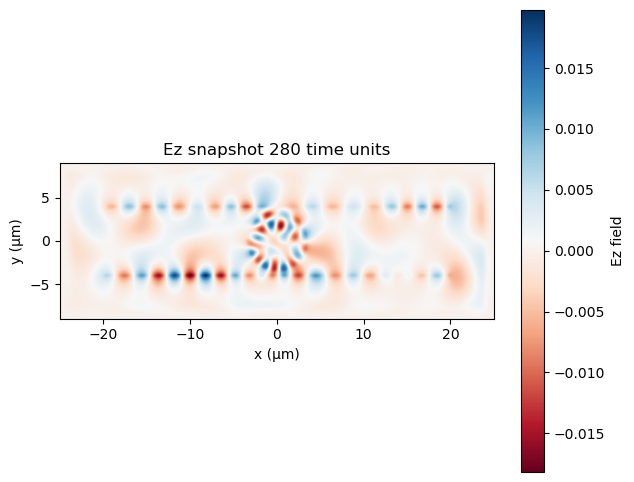

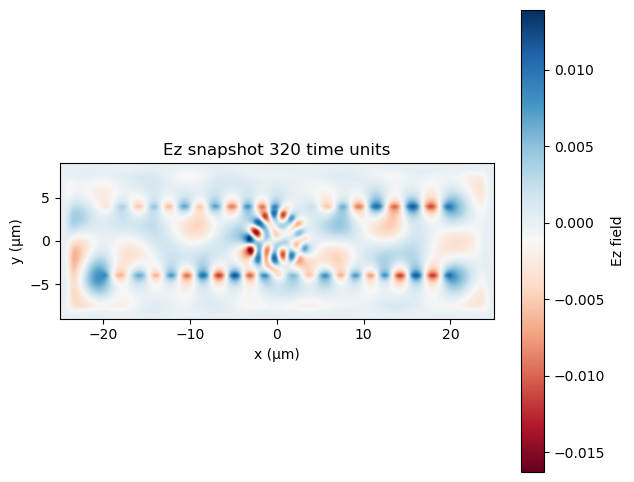

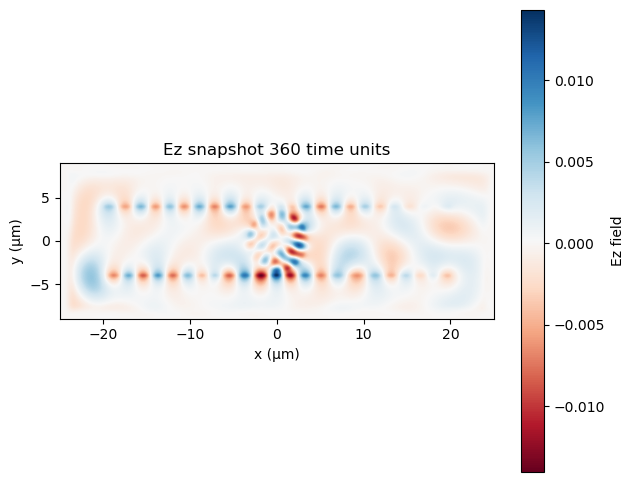

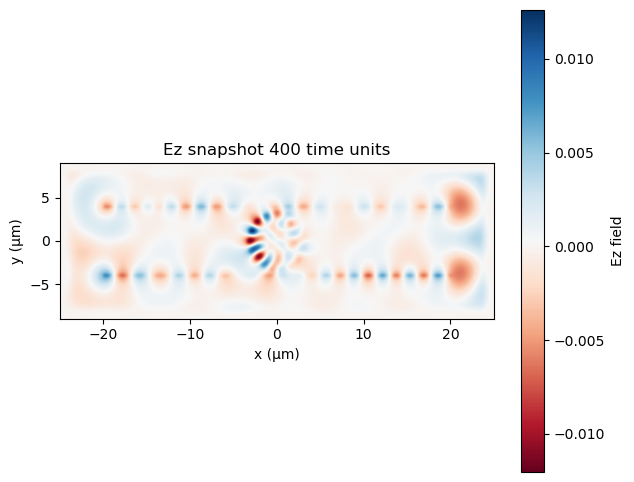

In [5]:
import meep as mp
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------
# Simulation parameters
# -----------------------------
resolution = 20  # pixels/um

# Materials
gaas = mp.Medium(epsilon=12)
air = mp.Medium(epsilon=1)

# Disk and waveguide geometry
disk_radius = 3.5
wg_length = 40
wg_width = 0.3
gap = 0.3  # distance between disk and waveguides

# Simulation cell size
cell_x = wg_length + 10
cell_y = 2*(disk_radius + gap + wg_width/2) + 10
cell = mp.Vector3(cell_x, cell_y, 0)

# PML layers
pml_layers = [mp.PML(2.0)]

# -----------------------------
# Geometry: disk + two waveguides
# -----------------------------
geometry = [
    mp.Cylinder(radius=disk_radius, height=mp.inf, center=mp.Vector3(0,0), material=gaas),
    mp.Block(size=mp.Vector3(wg_length, wg_width, mp.inf),
             center=mp.Vector3(0, disk_radius + gap + wg_width/2),
             material=gaas),   # bus waveguide (top)
    mp.Block(size=mp.Vector3(wg_length, wg_width, mp.inf),
             center=mp.Vector3(0, -disk_radius - gap - wg_width/2),
             material=gaas)   # drop waveguide (bottom)
]

# -----------------------------
# Source
# -----------------------------
source_x = -wg_length/2
source_y = disk_radius + gap + wg_width/2

fmin = 0.1
fmax = 0.2
df = fmax - fmin
nfreq = 300

sources = [mp.Source(mp.GaussianSource(frequency=(fmin+fmax)/2, fwidth=df),
                     component=mp.Ez,
                     center=mp.Vector3(source_x, source_y),
                     size=mp.Vector3(0, wg_width, 0))]

# -----------------------------
# Flux monitors
# -----------------------------
flux_region_disk = mp.FluxRegion(center=mp.Vector3(0,0), size=mp.Vector3(0, 2*disk_radius, 0))
flux_region_bus = mp.FluxRegion(center=mp.Vector3(wg_length/2 - 1, disk_radius + gap + wg_width/2),
                                size=mp.Vector3(0, wg_width, 0))
flux_region_drop = mp.FluxRegion(center=mp.Vector3(wg_length/2 - 1, -disk_radius - gap - wg_width/2),
                                 size=mp.Vector3(0, wg_width, 0))

# -----------------------------
# Simulation
# -----------------------------
sim = mp.Simulation(cell_size=cell,
                    geometry=geometry,
                    sources=sources,
                    boundary_layers=pml_layers,
                    resolution=resolution)

trans_flux_disk = sim.add_flux((fmin+fmax)/2, df, nfreq, flux_region_disk)
trans_flux_bus = sim.add_flux((fmin+fmax)/2, df, nfreq, flux_region_bus)
trans_flux_drop = sim.add_flux((fmin+fmax)/2, df, nfreq, flux_region_drop)



# -----------------------------
# Field snapshots storage
# -----------------------------
ez_data = []
def store_fields(sim):
    ez_data.append(sim.get_array(center=mp.Vector3(), size=cell, component=mp.Ez))

# Run simulation with snapshots
sim.run(mp.at_every(20, store_fields), until_after_sources=mp.stop_when_fields_decayed(
    50, mp.Ez, mp.Vector3(0,0), 1e-2))

# -----------------------------
# Extract flux spectra
# -----------------------------
frequencies = np.array(mp.get_flux_freqs(trans_flux_disk))
flux_disk = np.array(mp.get_fluxes(trans_flux_disk))
flux_bus = np.array(mp.get_fluxes(trans_flux_bus))
flux_drop = np.array(mp.get_fluxes(trans_flux_drop))

# -----------------------------
# Plot transmission spectra
# -----------------------------
plt.figure(figsize=(8,6))
plt.plot(frequencies, flux_disk, label="Flux in Disk")
plt.plot(frequencies, flux_bus, label="Bus Port (through)")
plt.plot(frequencies, flux_drop, label="Drop Port")
plt.xlabel("Frequency (1/µm)")
plt.ylabel("Flux")
plt.title("Resonator Transmission Spectra")
plt.legend()
plt.show()

# -----------------------------
# Plot Ez snapshots
# -----------------------------
for i, field in enumerate(ez_data):
    if i % 2 == 0:  # plot every 2nd snapshot
        plt.figure(figsize=(7,6))
        plt.imshow(np.rot90(field), cmap="RdBu", origin="lower",
                   extent=[-cell_x/2, cell_x/2, -cell_y/2, cell_y/2])
        plt.colorbar(label="Ez field")
        plt.title(f"Ez snapshot {i*20} time units")
        plt.xlabel("x (µm)")
        plt.ylabel("y (µm)")
        plt.show()


     cylinder, center = (0,0,0)
          radius 3.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,3.95,0)
          size (40,0.3,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-3.95,0)
          size (40,0.3,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)


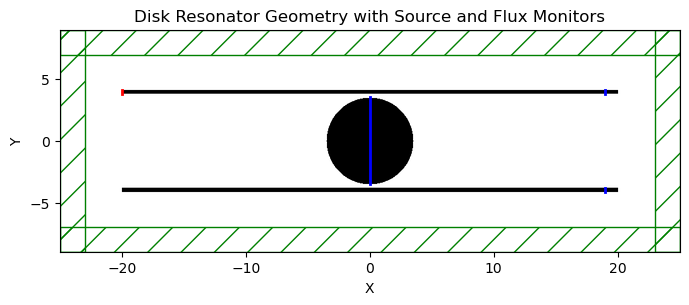

In [4]:
import meep as mp
import matplotlib.pyplot as plt

# -----------------------------
# Simulation parameters
# -----------------------------
resolution = 20  # pixels/um

gaas = mp.Medium(epsilon=12)
air = mp.Medium(epsilon=1)

disk_radius = 3.5
wg_length = 40
wg_width = 0.3
gap = 0.3

cell_x = wg_length + 10
cell_y = 2*(disk_radius + gap + wg_width/2) + 10
cell = mp.Vector3(cell_x, cell_y, 0)

pml_layers = [mp.PML(2.0)]

# -----------------------------
# Geometry
# -----------------------------
geometry = [
    mp.Cylinder(radius=disk_radius, height=mp.inf, center=mp.Vector3(0,0), material=gaas),
    mp.Block(size=mp.Vector3(wg_length, wg_width, mp.inf),
             center=mp.Vector3(0, disk_radius + gap + wg_width/2),
             material=gaas),   # bus waveguide
    mp.Block(size=mp.Vector3(wg_length, wg_width, mp.inf),
             center=mp.Vector3(0, -disk_radius - gap - wg_width/2),
             material=gaas)   # drop waveguide
]

# -----------------------------
# Source
# -----------------------------
source_x = -wg_length/2
source_y = disk_radius + gap + wg_width/2

fmin = 0.1
fmax = 0.2
df = fmax - fmin

sources = [mp.Source(mp.GaussianSource(frequency=(fmin+fmax)/2, fwidth=df),
                     component=mp.Ez,
                     center=mp.Vector3(source_x, source_y),
                     size=mp.Vector3(0, wg_width, 0))]

# -----------------------------
# Flux Monitors
# -----------------------------
flux_region_disk = mp.FluxRegion(center=mp.Vector3(0,0), size=mp.Vector3(0, 2*disk_radius, 0))
flux_region_bus  = mp.FluxRegion(center=mp.Vector3(wg_length/2 - 1, disk_radius + gap + wg_width/2),
                                 size=mp.Vector3(0, wg_width, 0))
flux_region_drop = mp.FluxRegion(center=mp.Vector3(wg_length/2 - 1, -disk_radius - gap - wg_width/2),
                                 size=mp.Vector3(0, wg_width, 0))

# -----------------------------
# Simulation (just for plotting)
# -----------------------------
sim = mp.Simulation(cell_size=cell,
                    geometry=geometry,
                    sources=sources,
                    boundary_layers=pml_layers,
                    resolution=resolution)

# Add flux objects (so they show up in the plot)
sim.add_flux((fmin+fmax)/2, df, 100, flux_region_disk)
sim.add_flux((fmin+fmax)/2, df, 100, flux_region_bus)
sim.add_flux((fmin+fmax)/2, df, 100, flux_region_drop)

# -----------------------------
# Plot geometry + sources + flux monitors
# -----------------------------
fig, ax = plt.subplots(figsize=(8,6))
sim.plot2D(ax=ax, output_plane=mp.Volume(center=mp.Vector3(), size=cell))
plt.title("Disk Resonator Geometry with Source and Flux Monitors")
plt.show()



In [25]:
# -----------------------------
# Harminv analysis inside the disk
# -----------------------------
fcen = 0.5 * (fmin + fmax)   # center of the frequency range
df_h = fmax - fmin           # frequency width to search

# monitor point: place inside disk where fields are strong
monitor_pt = mp.Vector3(0, 0, 0)

# run Harminv after the source has finished
sim.reset_meep()  # reset after your previous run, keep same geometry etc.
sim = mp.Simulation(cell_size=cell,
                    geometry=geometry,
                    sources=sources,
                    boundary_layers=pml_layers,
                    resolution=resolution)

sim.run(mp.after_sources(mp.Harminv(mp.Ez, monitor_pt, fcen, df_h)),
        until_after_sources=300)  # increase 300 for higher-Q modes


-----------
Initializing structure...
time for choose_chunkdivision = 0.000492096 s
Working in 2D dimensions.
Computational cell is 50 x 17.9 x 0 with resolution 20
     cylinder, center = (0,0,0)
          radius 3.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,3.95,0)
          size (40,0.3,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-3.95,0)
          size (40,0.3,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.698073 s
-----------


FloatProgress(value=0.0, description='0% done ', max=390.9090881347656)

Meep progress: 11.325000000000001/390.9090881347656 = 2.9% done in 4.0s, 134.2s to go
on time step 454 (time=11.35), 0.00881938 s/step


KeyboardInterrupt: 

-----------
Initializing structure...
time for choose_chunkdivision = 0.000390053 s
Working in 2D dimensions.
Computational cell is 50 x 17.9 x 0 with resolution 20
     cylinder, center = (0,0,0)
          radius 3.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,3.95,0)
          size (40,0.3,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-3.95,0)
          size (40,0.3,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.707888 s
-----------


FloatProgress(value=0.0, description='0% done ', max=290.9090881347656)

Meep progress: 13.725000000000001/290.9090881347656 = 4.7% done in 4.0s, 80.9s to go
on time step 549 (time=13.725), 0.00728973 s/step
Meep progress: 24.625/290.9090881347656 = 8.5% done in 8.0s, 86.8s to go
on time step 985 (time=24.625), 0.00922498 s/step
Meep progress: 33.300000000000004/290.9090881347656 = 11.4% done in 12.0s, 93.1s to go
on time step 1332 (time=33.3), 0.0115351 s/step
Meep progress: 44.25/290.9090881347656 = 15.2% done in 16.0s, 89.4s to go
on time step 1770 (time=44.25), 0.00916031 s/step
Meep progress: 56.85/290.9090881347656 = 19.5% done in 20.1s, 82.6s to go
on time step 2274 (time=56.85), 0.0079598 s/step
Meep progress: 66.47500000000001/290.9090881347656 = 22.9% done in 24.1s, 81.3s to go
on time step 2659 (time=66.475), 0.0104008 s/step
Meep progress: 73.15/290.9090881347656 = 25.1% done in 28.1s, 83.6s to go
on time step 2926 (time=73.15), 0.0150872 s/step
Meep progress: 81.30000000000001/290.9090881347656 = 27.9% done in 32.1s, 82.7s to go
on time step 32

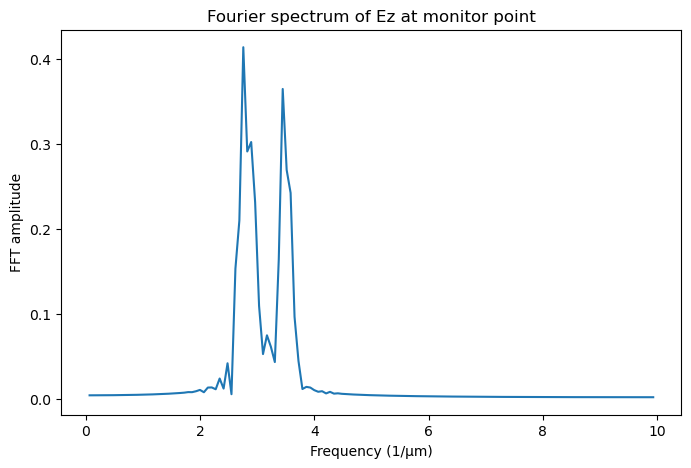

In [26]:
# -----------------------------
# Record field at monitor point
# -----------------------------
monitor_pt = mp.Vector3(0,0)   # inside the disk
time_signal = []

def store_signal(sim):
    time_signal.append(sim.get_field_point(mp.Ez, monitor_pt))

# Run with recording
sim.reset_meep()
sim.run(mp.at_every(1, store_signal), until_after_sources=200)

# -----------------------------
# Fourier transform to frequency domain
# -----------------------------
time_signal = np.array(time_signal)
freqs = np.fft.fftfreq(len(time_signal), d=1/resolution)  # d = time step ~ 1/resolution
spectrum = np.abs(np.fft.fft(time_signal))

# Only keep positive frequencies
mask = freqs > 0
freqs = freqs[mask]
spectrum = spectrum[mask]

# -----------------------------
# Plot
# -----------------------------
plt.figure(figsize=(8,5))
plt.plot(freqs, spectrum)
plt.xlabel("Frequency (1/µm)")
plt.ylabel("FFT amplitude")
plt.title("Fourier spectrum of Ez at monitor point")
plt.show()


-----------
Initializing structure...
time for choose_chunkdivision = 0.000558138 s
Working in 2D dimensions.
Computational cell is 50 x 17.8 x 0 with resolution 25
     cylinder, center = (0,0,0)
          radius 3.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,3.75,0)
          size (40,0.3,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)


          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-3.75,0)
          size (40,0.3,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 1.04879 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1425.0)

Meep progress: 8.78/1425.0 = 0.6% done in 4.0s, 645.8s to go
on time step 440 (time=8.8), 0.00910168 s/step
Meep progress: 17.84/1425.0 = 1.3% done in 8.0s, 631.9s to go
on time step 893 (time=17.86), 0.00884921 s/step
Meep progress: 30.66/1425.0 = 2.2% done in 12.0s, 546.6s to go
on time step 1534 (time=30.68), 0.00624623 s/step
Meep progress: 40.04/1425.0 = 2.8% done in 16.0s, 554.2s to go
on time step 2003 (time=40.06), 0.00853169 s/step
Meep progress: 49.5/1425.0 = 3.5% done in 20.0s, 556.4s to go
on time step 2476 (time=49.52), 0.00846105 s/step
Meep progress: 59.08/1425.0 = 4.1% done in 24.0s, 555.5s to go
on time step 2955 (time=59.1), 0.0083545 s/step
Meep progress: 68.2/1425.0 = 4.8% done in 28.0s, 557.6s to go
on time step 3411 (time=68.22), 0.00877906 s/step
Meep progress: 77.18/1425.0 = 5.4% done in 32.0s, 559.4s to go
on time step 3860 (time=77.2), 0.00891378 s/step
Meep progress: 86.68/1425.0 = 6.1% done in 36.0s, 556.4s to go
on time step 4335 (time=86.7), 0.00842793 s/s

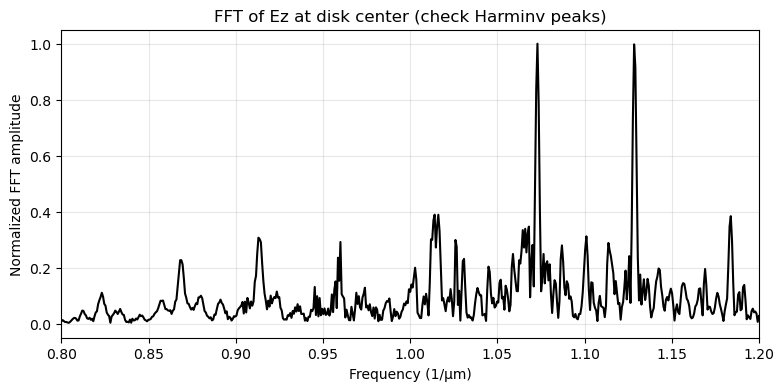

Resonance frequency (from FFT peak): 1.073003 1/µm
-----------
Initializing structure...
time for choose_chunkdivision = 0.000664949 s
Working in 2D dimensions.
Computational cell is 50 x 17.8 x 0 with resolution 25
     cylinder, center = (0,0,0)
          radius 3.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,3.75,0)
          size (40,0.3,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-3.75,0)
          size (40,0.3,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = -0.263071 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

Meep progress: 5.22/200.0 = 2.6% done in 4.0s, 149.4s to go
on time step 262 (time=5.24), 0.0153175 s/step
Meep progress: 9.3/200.0 = 4.7% done in 8.0s, 164.3s to go
on time step 467 (time=9.34), 0.0195724 s/step
Meep progress: 16.82/200.0 = 8.4% done in 12.0s, 130.9s to go
on time step 843 (time=16.86), 0.0106565 s/step
Meep progress: 24.72/200.0 = 12.4% done in 16.0s, 113.6s to go
on time step 1238 (time=24.76), 0.010147 s/step
Meep progress: 32.38/200.0 = 16.2% done in 20.0s, 103.7s to go
on time step 1620 (time=32.4), 0.0105185 s/step
Meep progress: 40.18/200.0 = 20.1% done in 24.0s, 95.6s to go
on time step 2012 (time=40.24), 0.0102151 s/step
Meep progress: 47.88/200.0 = 23.9% done in 28.1s, 89.1s to go
on time step 2397 (time=47.94), 0.0104056 s/step
Meep progress: 58.96/200.0 = 29.5% done in 32.1s, 76.7s to go
on time step 2951 (time=59.02), 0.00724971 s/step
Meep progress: 64.5/200.0 = 32.2% done in 36.1s, 75.8s to go
on time step 3230 (time=64.6), 0.0143695 s/step
Meep progres

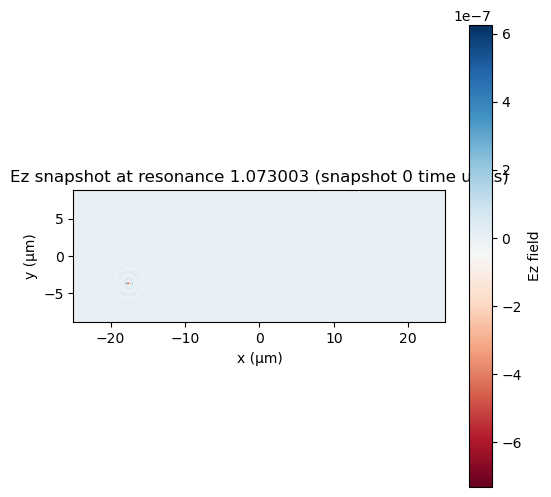

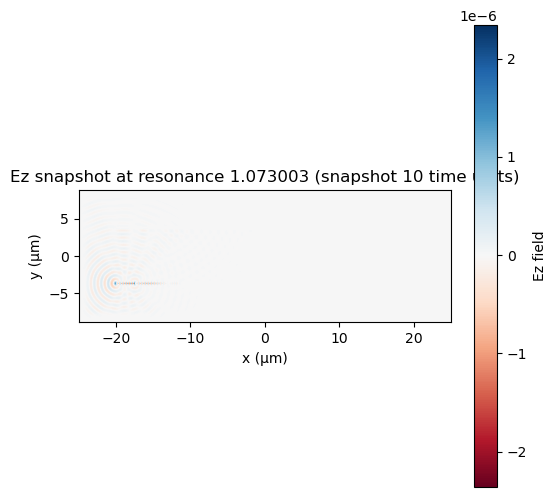

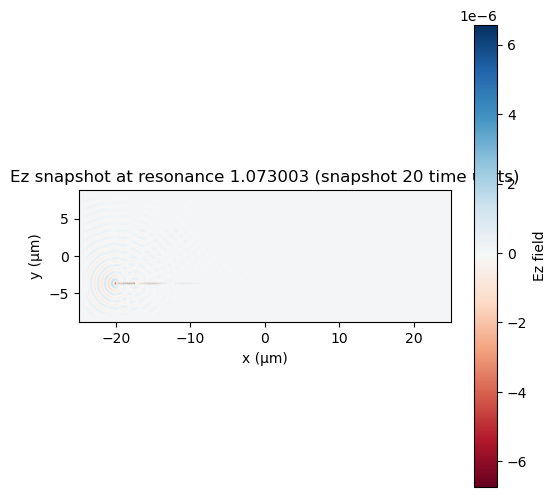

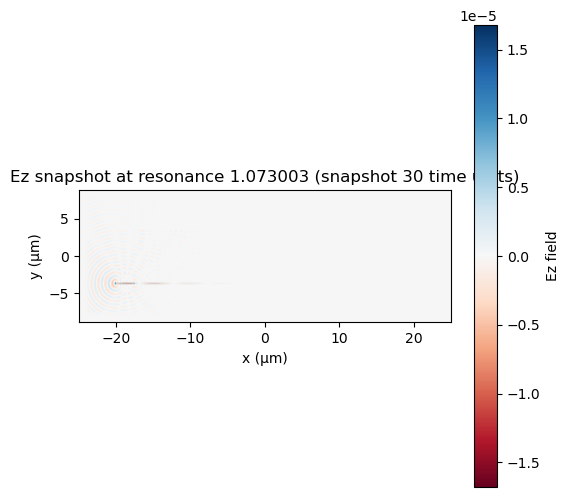

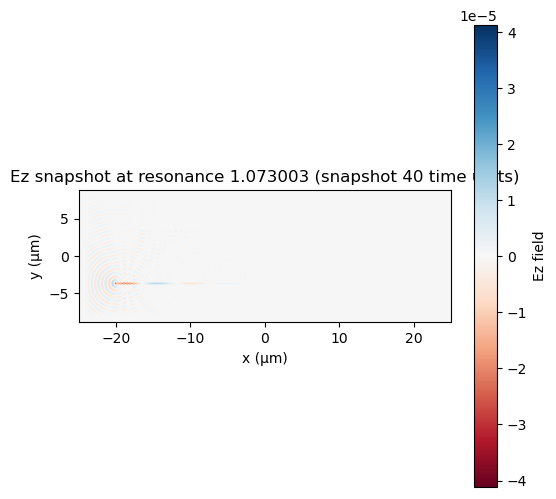

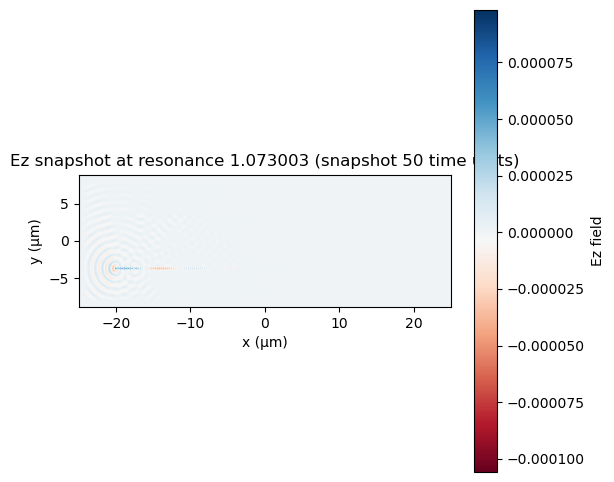

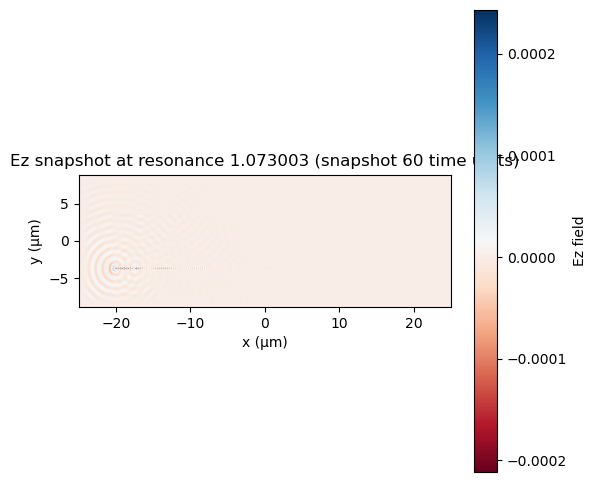

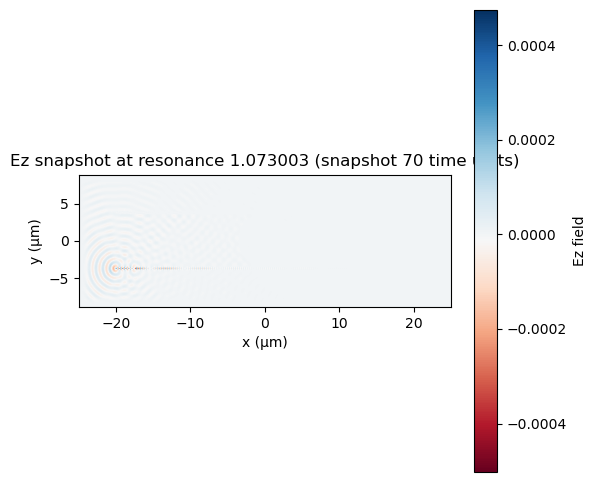

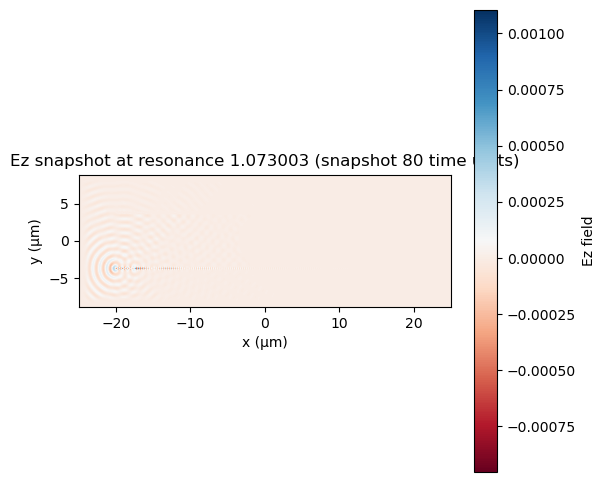

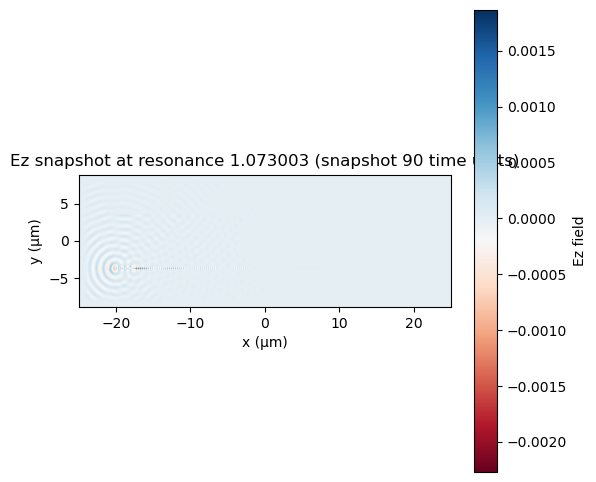

In [53]:
# -----------------------------
# Recommended: Harminv + well-sampled FFT
# -----------------------------
# (Replace your sim creation / sim.run lines with this block)

# 1) stronger resolution and more focused band (tune these values)
resolution = 25                     # increase spatial resolution (px / µm)
fcen = 1                        # center frequency to search (1/um) — adjust to expected band
fband = 0.2                         # total bandwidth around fcen to search (1/um)
fmin = fcen - fband/2
fmax = fcen + fband/2
nfreq = 800                        # if you still use DFT monitors

# Rebuild sim with higher resolution
sim = mp.Simulation(cell_size=cell,
                    geometry=geometry,
                    sources=sources,
                    boundary_layers=pml_layers,
                    resolution=resolution,
                    dimensions=2)

# Harminv parameters
harminv_center = fcen
harminv_band = fband

# Monitor point inside the disk (pick a point with expected strong field)
monitor_pt = mp.Vector3(disk_radius-0.2, 0)

# set longer "listen" time for high-Q modes
run_time_after_sources = 1400.0   # increase until peaks are sharp; may need 1000-2000 for very high Q

# 2) record a high-rate time signal at the monitor point for FFT
dt_sample = 0.05   # time sampling interval (choose <= 1/(2*max_expected_freq)); e.g. 0.05 is safe for f~1.0
time_signal = []
time_stamps = []

def store_signal(sim):
    time_signal.append(sim.get_field_point(mp.Ez, monitor_pt))
    time_stamps.append(sim.meep_time())

# Create Harminv analyser (will run after sources)
harminv = mp.Harminv(mp.Ez, monitor_pt, harminv_center, harminv_band)

# Run: both sampling and Harminv
sim.run(mp.at_every(dt_sample, store_signal), mp.after_sources(harminv),
        until_after_sources=run_time_after_sources)

# 3) FFT of recorded signal (properly sampled, windowed)
time_signal = np.array(time_signal)
time_stamps = np.array(time_stamps)
N = len(time_signal)
if N < 8:
    raise RuntimeError("Too few samples recorded — reduce dt_sample or increase total runtime.")

dt = np.mean(np.diff(time_stamps))
# window the signal to reduce leakage
window = np.hanning(N)
sig = time_signal * window

S = np.fft.fft(sig)
freqs = np.fft.fftfreq(N, d=dt)   # in Meep units (1/um)
mask = freqs > 0
freqs_pos = freqs[mask]
spec = np.abs(S[mask])

# Plot FFT spectrum and mark Harminv lines (Harminv prints results to console)
plt.figure(figsize=(9,4))
plt.plot(freqs_pos, spec / spec.max(), '-k', label='FFT spectrum (monitor point)')
plt.xlim(fcen - fband, fcen + fband)
plt.xlabel('Frequency (1/µm)')
plt.ylabel('Normalized FFT amplitude')
plt.title('FFT of Ez at disk center (check Harminv peaks)')
plt.grid(alpha=0.3)
plt.show()

# 4) (Optional) If you want to visualize Harminv results programmatically,
# they are printed to stdout during the run. Manually read the reported frequencies
# from the console and overlay vertical lines on the FFT plot:
# Example: harminv_freqs = [0.92, 0.95, 0.98]  # replace with printed values
# for f in harminv_freqs: plt.axvline(f, color='r', ls='--')

# 5) If you still want the flux in the disk for a narrow band, you can add a DFT/flux monitor
# matching the focused band (but Harminv + FFT at disk center is your most reliable resonance detector).

# -----------------------------
# 6) Extract peak frequency from FFT
# -----------------------------
max_idx = np.argmax(spec)
resonance_freq = freqs_pos[max_idx]
print(f"Resonance frequency (from FFT peak): {resonance_freq:.6f} 1/µm")

# -----------------------------
# 7) Run a new simulation at the resonance frequency
# -----------------------------
# Use a narrow Gaussian centered at the resonance frequency
fwidth_res = 0.01 * resonance_freq  # narrow enough to excite mostly the mode
sources_res = [mp.Source(mp.GaussianSource(frequency=resonance_freq, fwidth=fwidth_res),
                         component=mp.Ez,
                         center=mp.Vector3(source_x, source_y),
                         size=mp.Vector3(0, wg_width, 0))]

sim_res = mp.Simulation(cell_size=cell,
                        geometry=geometry,
                        sources=sources_res,
                        boundary_layers=pml_layers,
                        resolution=resolution,
                        dimensions=2)

# -----------------------------
# 8) Store Ez snapshots during this resonant run
# -----------------------------
ez_snapshots = []

def store_snapshot(sim):
    ez_snapshots.append(sim.get_array(center=mp.Vector3(), size=cell, component=mp.Ez))

# Run and store snapshots every 2 time units for visualization
sim_res.run(mp.at_every(2, store_snapshot), until=200)  # increase until field is established

# -----------------------------
# 9) Plot some snapshots of the resonant mode
# -----------------------------
for i, field in enumerate(ez_snapshots[::10]):  # plot every 5th snapshot
    plt.figure(figsize=(6,6))
    plt.imshow(np.rot90(field), cmap="RdBu", origin="lower",
               extent=[-cell.x/2, cell.x/2, -cell.y/2, cell.y/2])
    plt.colorbar(label="Ez field")
    plt.title(f"Ez snapshot at resonance {resonance_freq:.6f} (snapshot {i*5*2} time units)")
    plt.xlabel("x (µm)")
    plt.ylabel("y (µm)")
    plt.show()


-----------
Initializing structure...
time for choose_chunkdivision = 0.00109506 s
Working in 2D dimensions.
Computational cell is 50 x 17.9 x 0 with resolution 30
     cylinder, center = (0,0,0)
          radius 3.5, height 1e+20, axis (0, 0, 1)


          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,3.95,0)
          size (40,0.3,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-3.95,0)
          size (40,0.3,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 1.43469 s
-----------


FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 5.133333333333333/300.0 = 1.7% done in 4.0s, 230.4s to go
on time step 308 (time=5.13333), 0.0130067 s/step
Meep progress: 8.366666666666667/300.0 = 2.8% done in 8.0s, 279.7s to go
on time step 502 (time=8.36667), 0.0206756 s/step
Meep progress: 11.433333333333334/300.0 = 3.8% done in 12.0s, 303.5s to go
on time step 686 (time=11.4333), 0.0217421 s/step
Meep progress: 15.466666666666667/300.0 = 5.2% done in 16.0s, 295.0s to go
on time step 928 (time=15.4667), 0.0165492 s/step
Meep progress: 19.616666666666667/300.0 = 6.5% done in 20.0s, 286.4s to go
on time step 1177 (time=19.6167), 0.0160839 s/step
Meep progress: 24.1/300.0 = 8.0% done in 24.0s, 275.2s to go
on time step 1447 (time=24.1167), 0.0148696 s/step
Meep progress: 28.933333333333334/300.0 = 9.6% done in 28.0s, 262.7s to go
on time step 1738 (time=28.9667), 0.0137892 s/step
Meep progress: 34.416666666666664/300.0 = 11.5% done in 32.0s, 247.3s to go
on time step 2068 (time=34.4667), 0.0121554 s/step
Meep progress

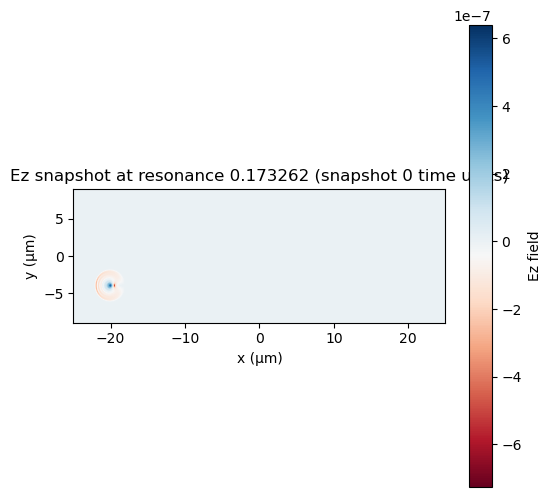

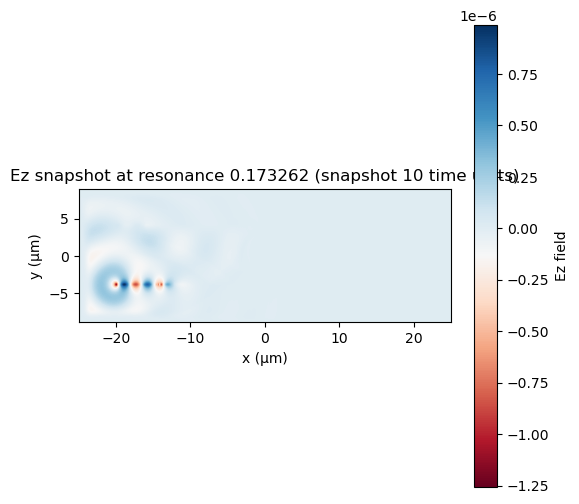

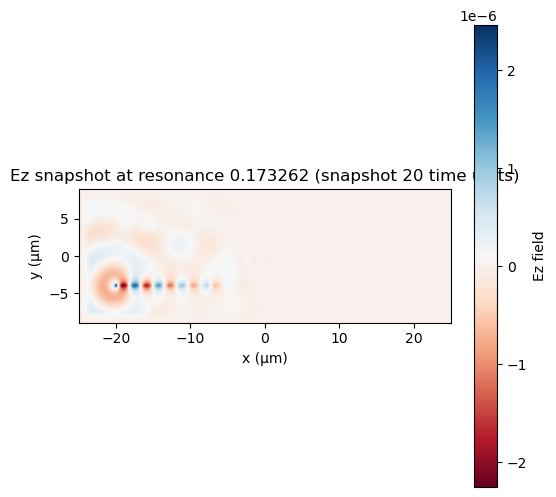

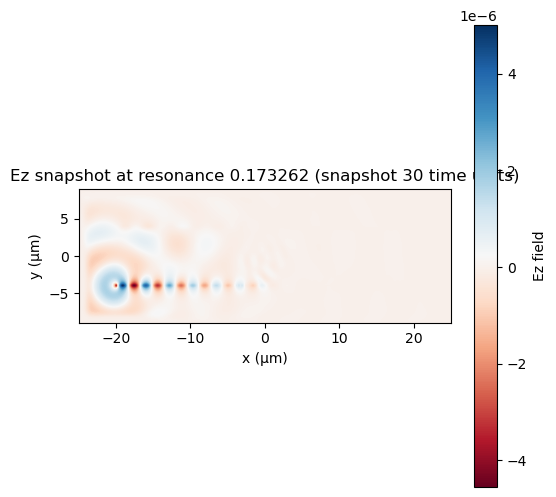

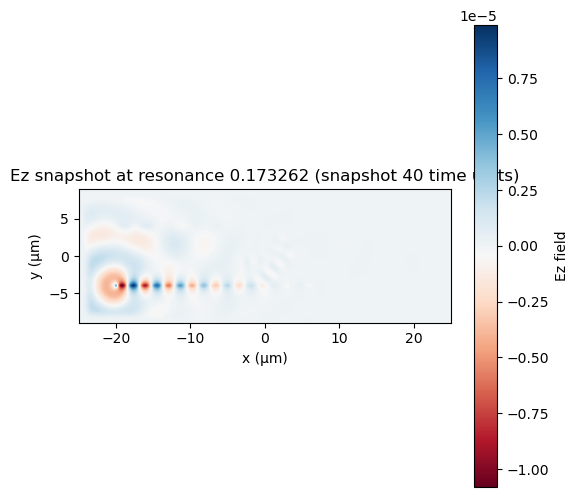

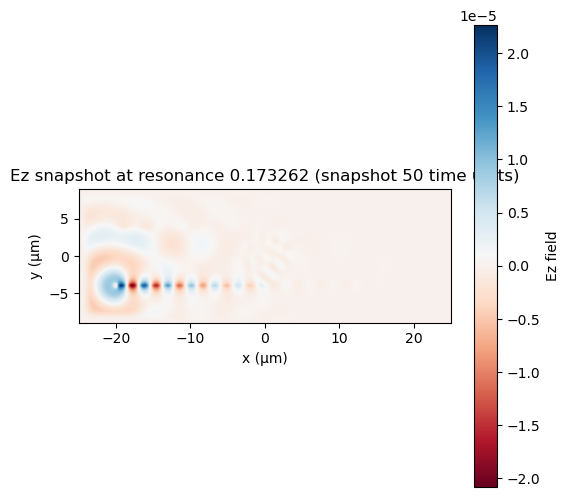

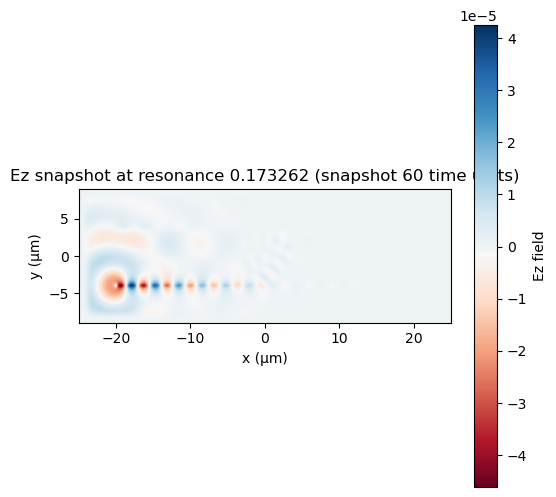

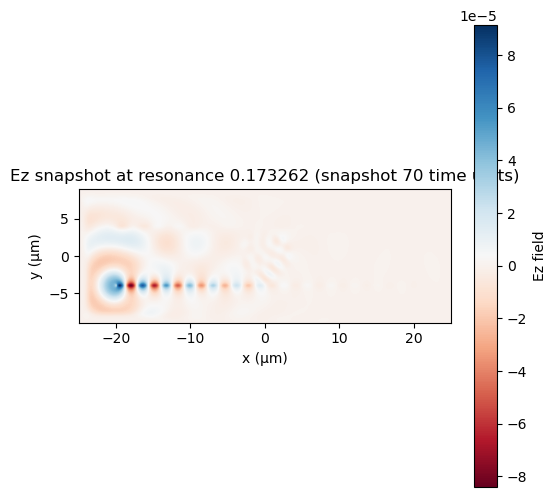

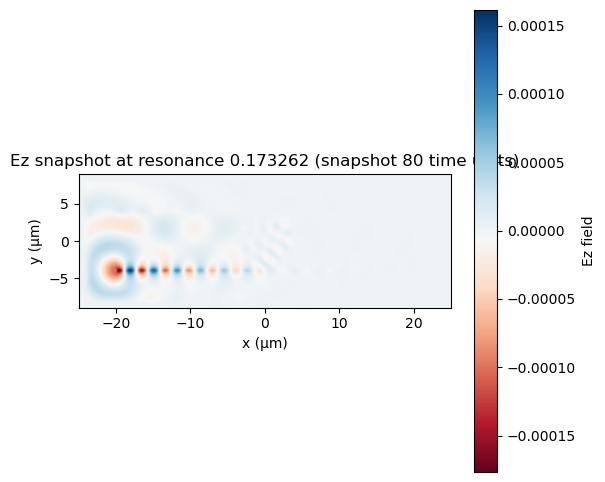

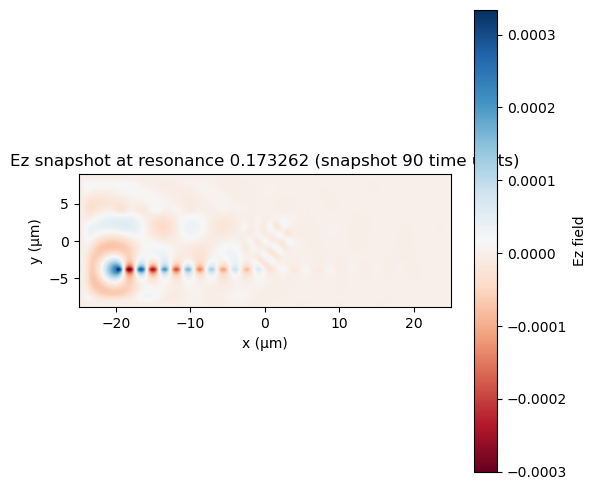

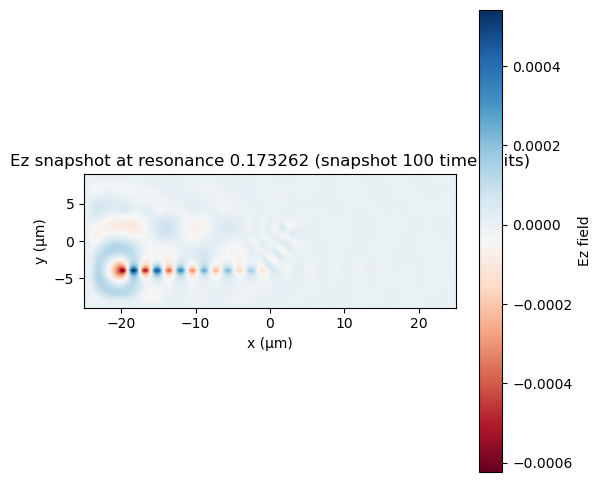

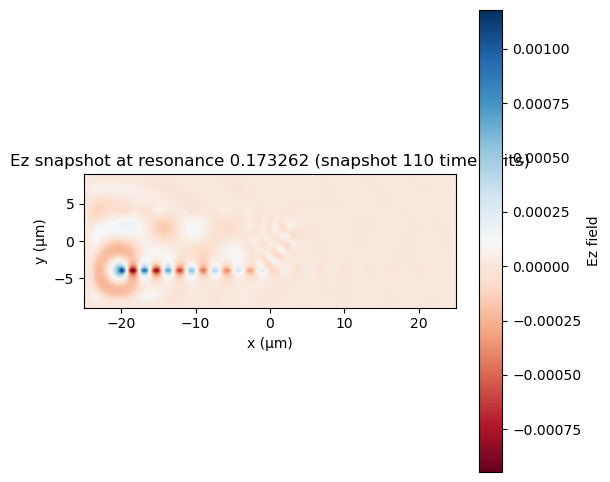

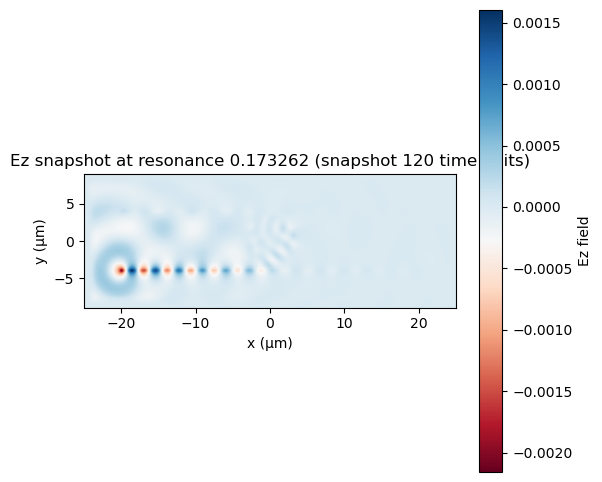

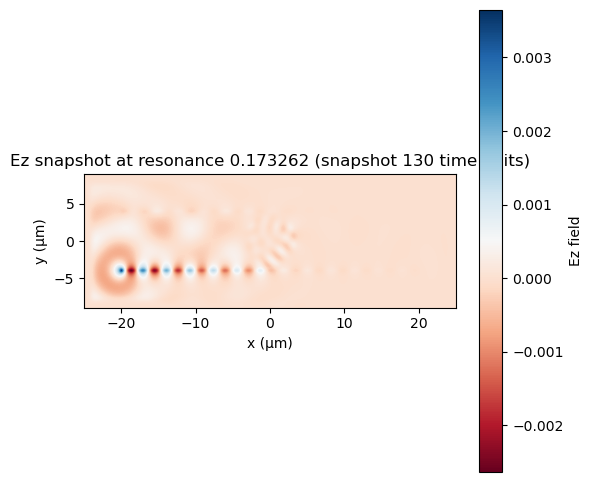

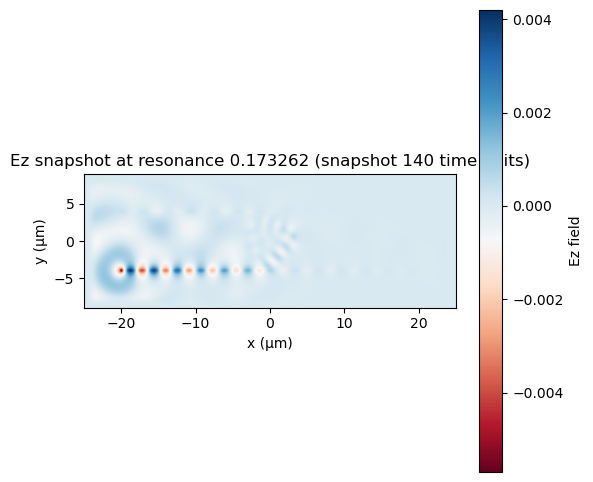

In [45]:
# -----------------------------
# 7) Run a new simulation at the resonance frequency
# -----------------------------
# Use a narrow Gaussian centered at the resonance frequency
fwidth_res = 0.05 * resonance_freq  # narrow enough to excite mostly the mode
sources_res = [mp.Source(mp.GaussianSource(frequency=resonance_freq, fwidth=fwidth_res),
                         component=mp.Ez,
                         center=mp.Vector3(source_x, source_y),
                         size=mp.Vector3(0, wg_width, 0))]

sim_res = mp.Simulation(cell_size=cell,
                        geometry=geometry,
                        sources=sources_res,
                        boundary_layers=pml_layers,
                        resolution=resolution,
                        dimensions=2)

# -----------------------------
# 8) Store Ez snapshots during this resonant run
# -----------------------------
ez_snapshots = []

def store_snapshot(sim):
    ez_snapshots.append(sim.get_array(center=mp.Vector3(), size=cell, component=mp.Ez))

# Run and store snapshots every 2 time units for visualization
sim_res.run(mp.at_every(2, store_snapshot), until=300)  # increase until field is established

# -----------------------------
# 9) Plot some snapshots of the resonant mode
# -----------------------------
for i, field in enumerate(ez_snapshots[::10]):  # plot every 5th snapshot
    plt.figure(figsize=(6,6))
    plt.imshow(np.rot90(field), cmap="RdBu", origin="lower",
               extent=[-cell.x/2, cell.x/2, -cell.y/2, cell.y/2])
    plt.colorbar(label="Ez field")
    plt.title(f"Ez snapshot at resonance {resonance_freq:.6f} (snapshot {i*5*2} time units)")
    plt.xlabel("x (µm)")
    plt.ylabel("y (µm)")
    plt.show()

-----------
Initializing structure...
time for choose_chunkdivision = 0.000547886 s
Working in 2D dimensions.
Computational cell is 50 x 17.9 x 0 with resolution 20
     cylinder, center = (0,0,0)
          radius 3.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,3.95,0)
          size (40,0.3,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-3.95,0)
          size (40,0.3,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)


time for set_epsilon = 0.708559 s
-----------
on time step 476 (time=11.9), 0.00841066 s/step
on time step 1129 (time=28.225), 0.00613213 s/step
on time step 1829 (time=45.725), 0.00571817 s/step
field decay(t = 50.025000000000006): 0.3308483864591213 / 0.3308483864591213 = 1.0
on time step 2477 (time=61.925), 0.00617621 s/step
on time step 3167 (time=79.175), 0.00580034 s/step
field decay(t = 100.05000000000001): 0.31463488988831984 / 0.3308483864591213 = 0.9509941797077353
on time step 4219 (time=105.475), 0.00380455 s/step
on time step 4897 (time=122.425), 0.00590264 s/step
on time step 5636 (time=140.9), 0.00541277 s/step
field decay(t = 150.07500000000002): 0.005546535206544315 / 0.3308483864591213 = 0.01676458291335699
on time step 6284 (time=157.1), 0.00617342 s/step
on time step 6968 (time=174.2), 0.00585088 s/step
on time step 7731 (time=193.275), 0.00524606 s/step
field decay(t = 200.10000000000002): 0.002957898268878898 / 0.3308483864591213 = 0.008940343643611414
run 0 finis

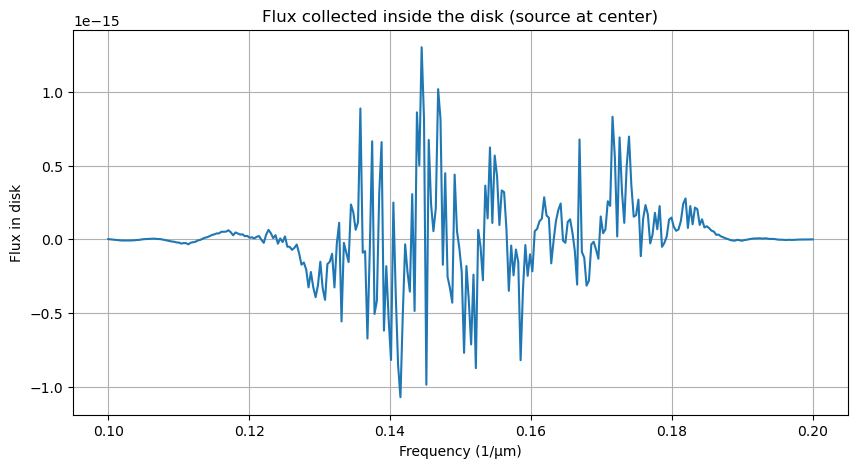

Maximum flux at frequency: 0.144482 1/µm


FloatProgress(value=200.10000610351562, description='0% done ', max=250.10000610351562, min=200.10000610351562…

on time step 8351 (time=208.775), 0.00645184 s/step
Meep progress: 15.67499389648438/250.10000610351562 = 6.3% done in 4.0s, 59.8s to go
on time step 9324 (time=233.1), 0.00411675 s/step
Meep progress: 38.2499938964844/250.10000610351562 = 15.3% done in 8.0s, 44.4s to go
on time step 9767 (time=244.175), 0.00905844 s/step
Meep progress: 49.074993896484386/250.10000610351562 = 19.6% done in 12.0s, 49.2s to go
run 1 finished at t = 250.10000000000002 (10004 timesteps)


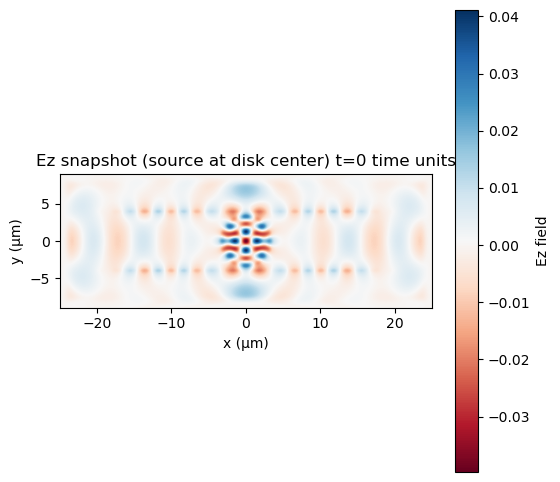

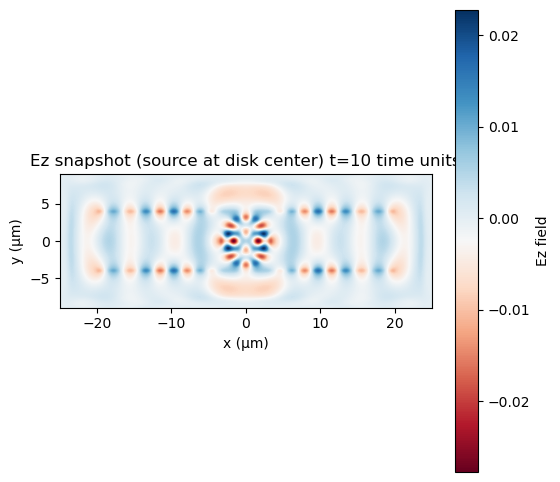

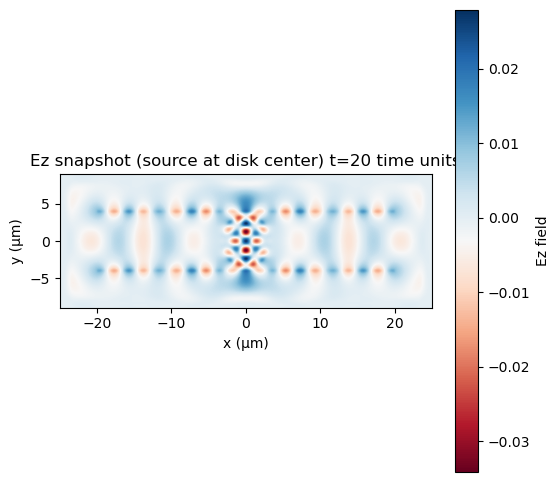

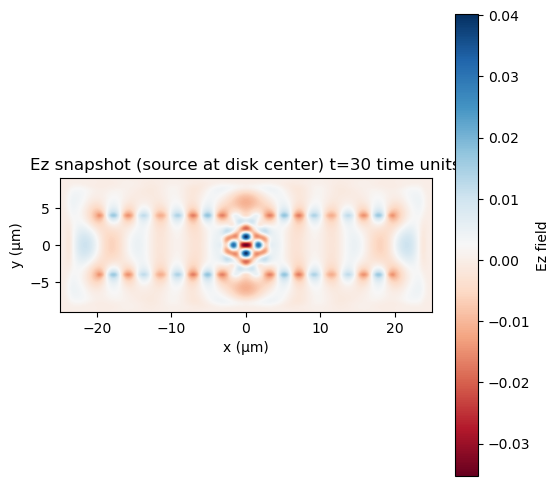

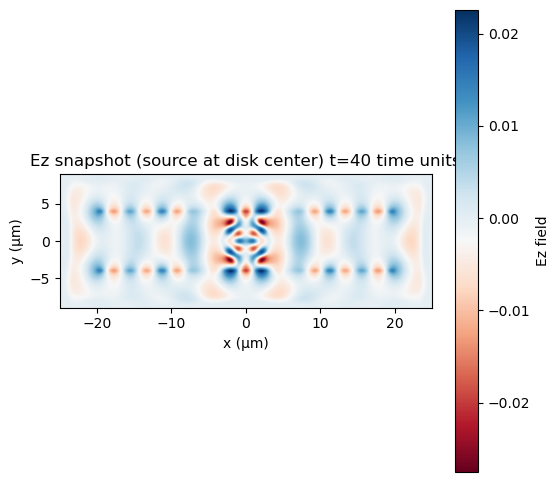

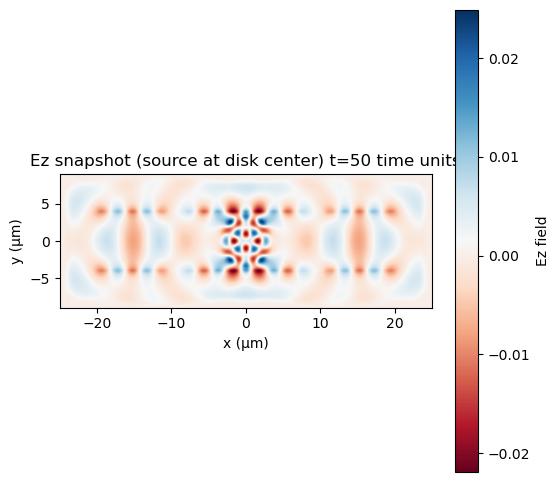

In [31]:

# -----------------------------
# Simulation parameters
# -----------------------------
resolution = 20  # pixels per µm
disk_radius = 3.5
wg_length = 40
wg_width = 0.3
gap = 0.3

# Materials
gaas = mp.Medium(epsilon=12)
air = mp.Medium(epsilon=1)

# Simulation cell
cell_x = wg_length + 10
cell_y = 2*(disk_radius + gap + wg_width/2) + 10
cell = mp.Vector3(cell_x, cell_y, 0)

# PML boundaries
pml_layers = [mp.PML(2.0)]

# -----------------------------
# Geometry: disk + two waveguides
# -----------------------------
geometry = [
    mp.Cylinder(radius=disk_radius, height=mp.inf, center=mp.Vector3(0,0), material=gaas),
    mp.Block(size=mp.Vector3(wg_length, wg_width, mp.inf),
             center=mp.Vector3(0, disk_radius + gap + wg_width/2), material=gaas),
    mp.Block(size=mp.Vector3(wg_length, wg_width, mp.inf),
             center=mp.Vector3(0, -disk_radius - gap - wg_width/2), material=gaas)
]

# -----------------------------
# Source in the center of the disk
# -----------------------------
source_x = 0
source_y = 0

fmin = 0.1
fmax = 0.2
df = fmax - fmin
nfreq = 300

sources = [mp.Source(mp.GaussianSource(frequency=(fmin+fmax)/2, fwidth=df),
                     component=mp.Ez,
                     center=mp.Vector3(source_x, source_y),
                     size=mp.Vector3(0,0,0))]  # point source at disk center

# -----------------------------
# Flux monitor: inside disk (to measure resonance)
# -----------------------------
flux_region = mp.FluxRegion(center=mp.Vector3(0,0), size=mp.Vector3(0, 2*disk_radius, 0))

# -----------------------------
# Simulation
# -----------------------------
sim = mp.Simulation(cell_size=cell,
                    geometry=geometry,
                    sources=sources,
                    boundary_layers=pml_layers,
                    resolution=resolution)

trans_flux = sim.add_flux((fmin+fmax)/2, df, nfreq, flux_region)

# Run until fields decay
sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, mp.Vector3(0,0), 1e-2))

# -----------------------------
# Extract flux
# -----------------------------
frequencies = np.array(mp.get_flux_freqs(trans_flux))
transmission = np.array(mp.get_fluxes(trans_flux))

# -----------------------------
# Plot flux spectrum
# -----------------------------
plt.figure(figsize=(10,5))
plt.plot(frequencies, transmission)
plt.xlabel("Frequency (1/µm)")
plt.ylabel("Flux in disk")
plt.title("Flux collected inside the disk (source at center)")
plt.grid(True)
plt.show()

# -----------------------------
# Find resonance frequency
# -----------------------------
max_idx = np.argmax(transmission)
resonance_freq = frequencies[max_idx]
print(f"Maximum flux at frequency: {resonance_freq:.6f} 1/µm")

# -----------------------------
# Store Ez snapshots for visualization
# -----------------------------
ez_snapshots = []

def store_field(sim):
    ez_snapshots.append(sim.get_array(center=mp.Vector3(), size=cell, component=mp.Ez))

# Run simulation again to store snapshots
sim.run(mp.at_every(2, store_field), until=50)

# Plot some snapshots
for i, field in enumerate(ez_snapshots[::5]):  # every 5th snapshot
    plt.figure(figsize=(6,6))
    plt.imshow(np.rot90(field), cmap="RdBu", origin="lower",
               extent=[-cell_x/2, cell_x/2, -cell_y/2, cell_y/2])
    plt.colorbar(label="Ez field")
    plt.title(f"Ez snapshot (source at disk center) t={i*5*2} time units")
    plt.xlabel("x (µm)")
    plt.ylabel("y (µm)")
    plt.show()
